# Homicides in the South

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer

C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('../data/south_homicides.csv')

In [3]:
data.head(20)

,fid,primaryindex,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,FIPSNO,...,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,lon,lat
0,1,1,Hancock,West Virginia,54,29,54029,54,29,54029,...,0.223645,0.295377,0.332251,0.363934,9.981297,7.8,9.785797,12.604552,-80.578702,40.520355
1,2,2,Brooke,West Virginia,54,9,54009,54,9,54009,...,0.220407,0.318453,0.314165,0.350569,10.929337,8.0,10.214990,11.242293,-80.579875,40.274649
2,3,3,Ohio,West Virginia,54,69,54069,54,69,54069,...,0.272398,0.358454,0.376963,0.390534,15.621643,12.9,14.716681,17.574021,-80.622604,40.099872
3,4,4,Marshall,West Virginia,54,51,54051,54,51,54051,...,0.227647,0.319580,0.320953,0.377346,11.962834,8.8,8.803253,13.564159,-80.666062,39.861063
4,5,5,New Castle,Delaware,10,3,10003,10,3,10003,...,0.256106,0.329678,0.365830,0.332703,12.035714,10.7,15.169480,16.380903,-75.650102,39.584505
5,6,6,Washington,Maryland,24,43,24043,24,43,24043,...,0.257266,0.334819,0.343903,0.344267,12.273212,9.3,10.501908,13.093521,-77.814438,39.603483
6,7,7,Allegany,Maryland,24,1,24001,24,1,24001,...,0.259956,0.335631,0.344512,0.384318,14.503302,11.0,11.739130,15.502258,-78.698318,39.621918
7,8,8,Cecil,Maryland,24,15,24015,24,15,24015,...,0.253666,0.323361,0.328207,0.332786,10.905885,8.4,10.074674,12.651254,-75.941322,39.584736
8,9,9,Garrett,Maryland,24,23,24023,24,23,24023,...,0.339693,0.365432,0.361536,0.371719,12.140380,8.9,9.443270,10.887149,-79.275203,39.528014
9,10,10,Harford,Maryland,24,25,24025,24,25,24025,...,0.256384,0.312853,0.325357,0.318068,9.680950,7.8,10.348491,11.344855,-76.324310,39.567028


In [4]:
homicide_rate = data['HC90']

In [5]:
homicide_rate

0        0.333333
1        0.333333
2        1.333333
3        1.666667
4       29.666667
          ...    
1407     4.333333
1408     1.666667
1409     2.666667
1410     2.333333
1411     9.333333
Name: HC90, Length: 1412, dtype: float64

In [6]:
features = data[['PO90', 'RD90', 'PS90', 'UE90', 'DV90', 'MA90', 'MFIL89', 'FP89', 'BLK90', 'GI89', 'FH90', 'DNL90', 'lon', 'lat']]

In [7]:
loc = data[['lon', 'lat']]

In [8]:
X_train, X_temp, y_train, y_temp, loc_train, loc_temp = train_test_split(features, homicide_rate, loc, train_size=0.8, random_state=42)

In [9]:
X_calib, X_test, y_calib, y_test, loc_calib, loc_test = train_test_split(X_temp, y_temp, loc_temp, train_size=0.5, random_state=42)

In [10]:
model = xgb.XGBRegressor(n_estimators=400, max_depth=3, min_child_weight=0.8, colsample_bytree=0.8, objective='count:poisson')

In [11]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=0.8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, objective='count:poisson', ...)

In [12]:
model.score(X_test, y_test)

0.771506177615359

In [13]:
explainer = GeoConformalizedExplainer(model, X_train, X_calib, loc_calib.values, loc_test.values, 0.1, 3)

In [14]:
results = explainer.uncertainty_aware_explain(x_test=X_test)

Training SHAP


PermutationExplainer explainer: 1130it [04:11,  4.41it/s]                          


Calibrating SHAP


PermutationExplainer explainer: 142it [00:32,  3.15it/s]                         


Testing SHAP


PermutationExplainer explainer: 143it [00:29,  3.00it/s]                         


Explaining Variables


C:\Users\Xiayin\PycharmProjects\UncertaintyGeoXAI\GeoConformalizedExplainer\GeoConformalizedExplainer.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['y'] = self.coords[:, 1]


In [15]:
results.accuracy_summary()

,coverage_probability,R2,RMSE,SHAP_Var,Pred_SHAP_Var
PO90,0.887324,0.863158,4.863106,172.825873,257.654942
RD90,0.943662,0.387568,0.459922,0.345391,0.343159
PS90,0.943662,0.835307,3.158608,60.578328,101.352224
UE90,0.901408,0.341184,0.818659,1.017283,1.510448
DV90,0.915493,0.836920,0.446045,1.219995,1.025709
MA90,0.922535,-0.373592,1.050506,0.803414,0.078713
MFIL89,0.788732,-0.948069,0.409502,0.086081,0.088249
FP89,0.852113,0.077793,0.775335,0.651854,0.277909
BLK90,0.929577,-0.676971,2.108958,2.652224,2.697835
GI89,0.859155,0.002549,0.507377,0.258090,0.053150


In [16]:
results.accuracy_summary().to_csv('SoutheHomicides_accuracy_summary.csv')

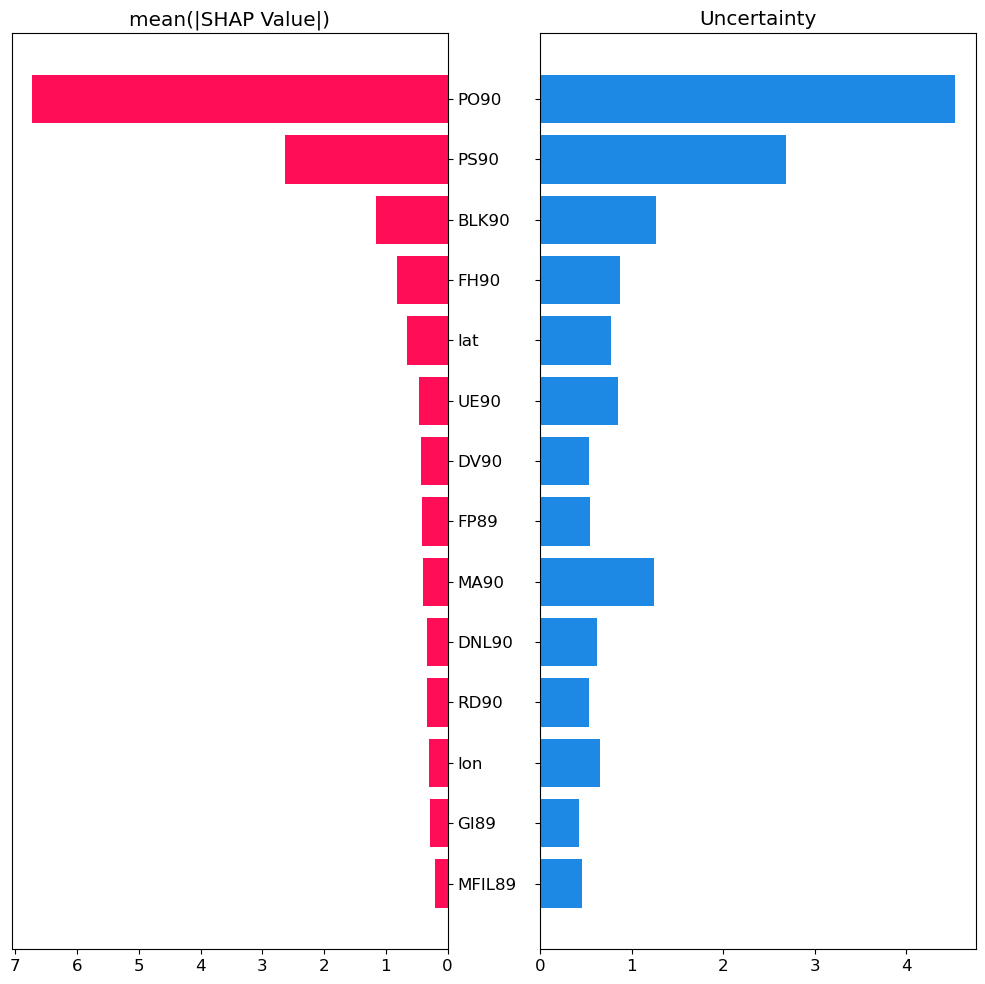

In [17]:
results.plot_absolute_shap_value_with_uncertainty(filename='SoutheHomicides_absolute_shap_value_with_uncertainty.pdf')

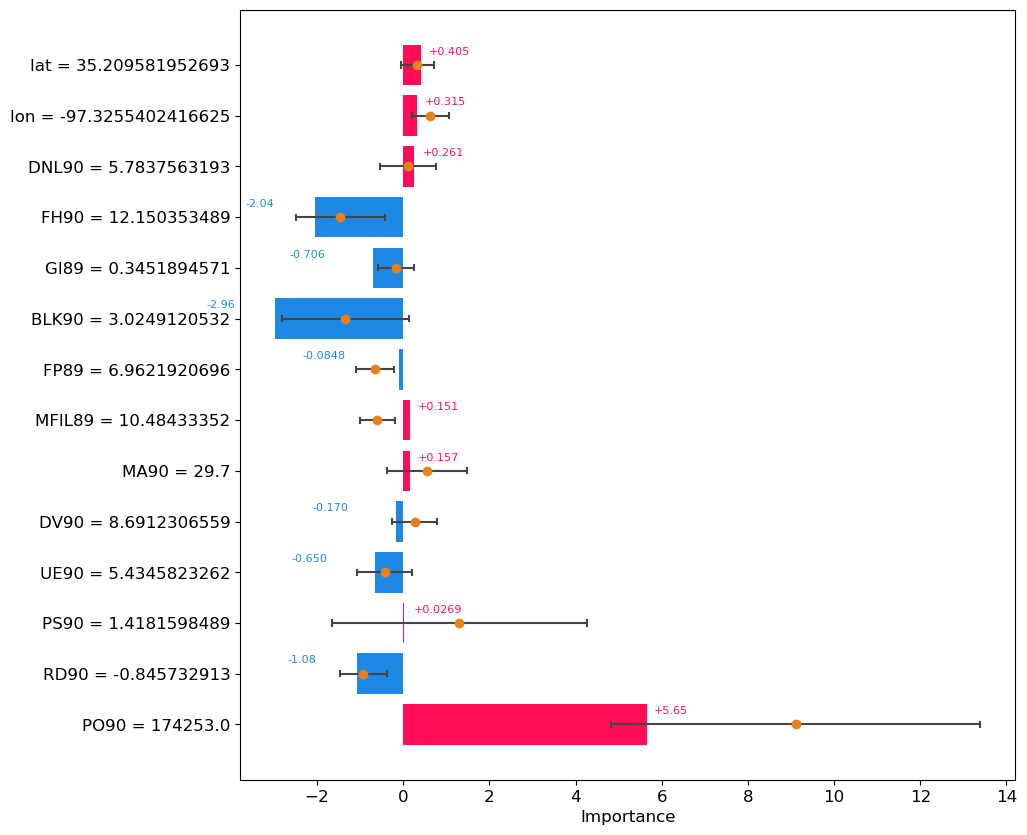

In [21]:
results.plot_shap_values_with_uncertainty(15, filename='SoutheHomicides_shap_values_with_uncertainty.pdf')

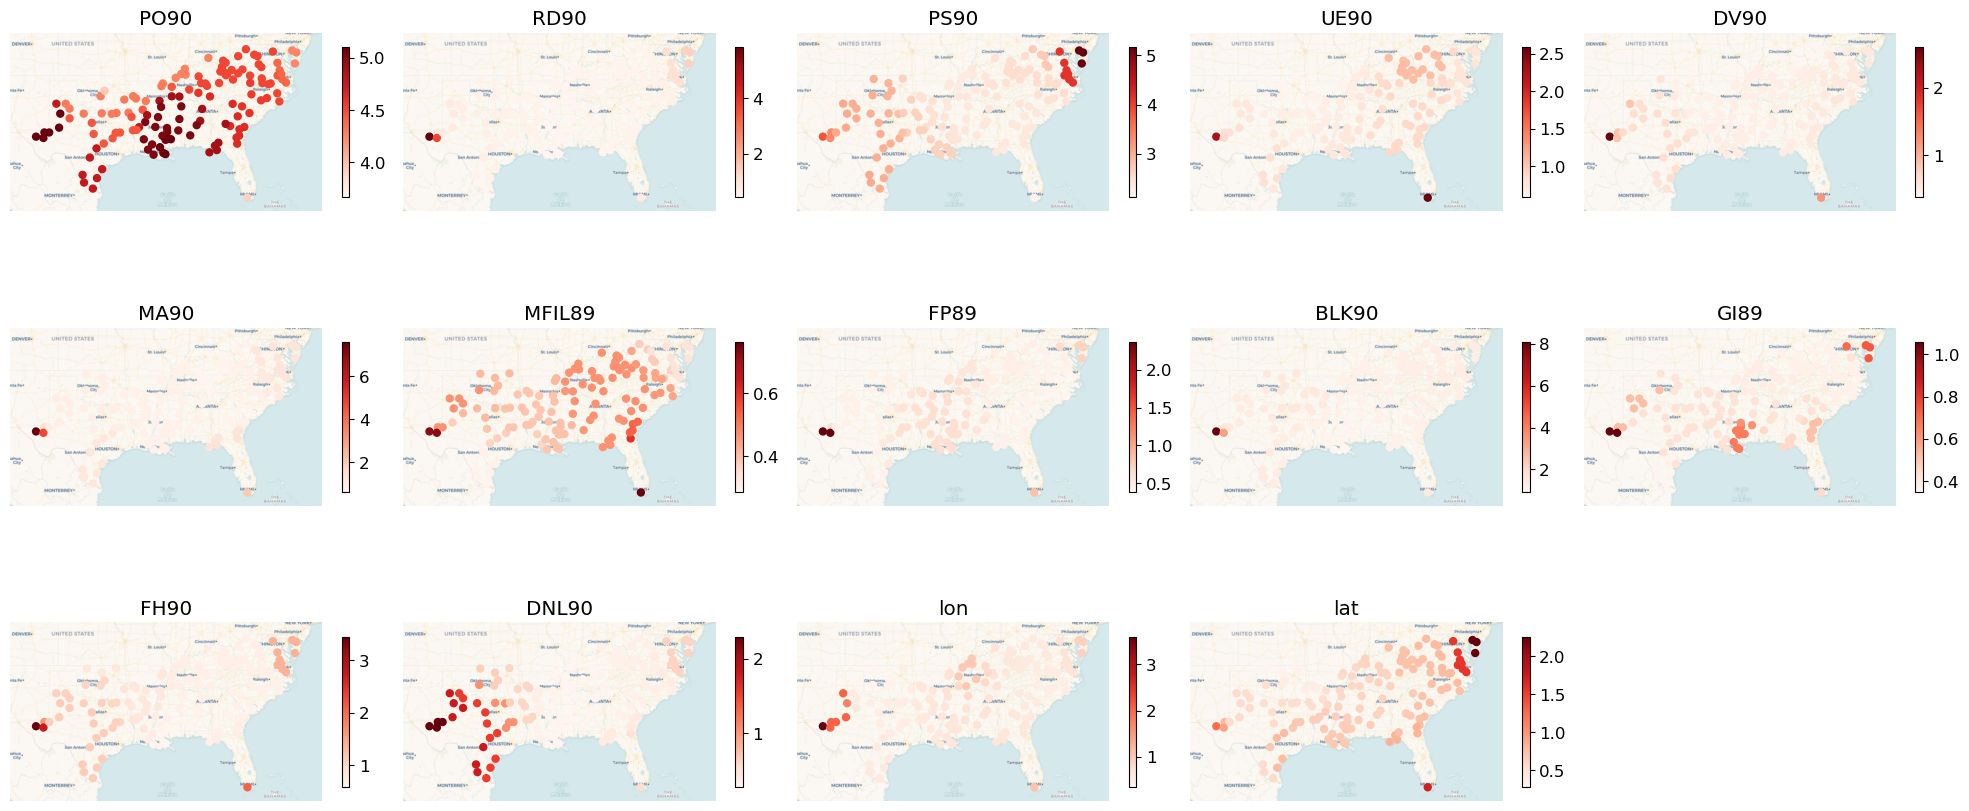

In [19]:
results.plot_geo_uncertainty(figsize=(20, 10), shrink=0.4, filename='SoutheHomicides_geo_uncertainty.pdf')

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

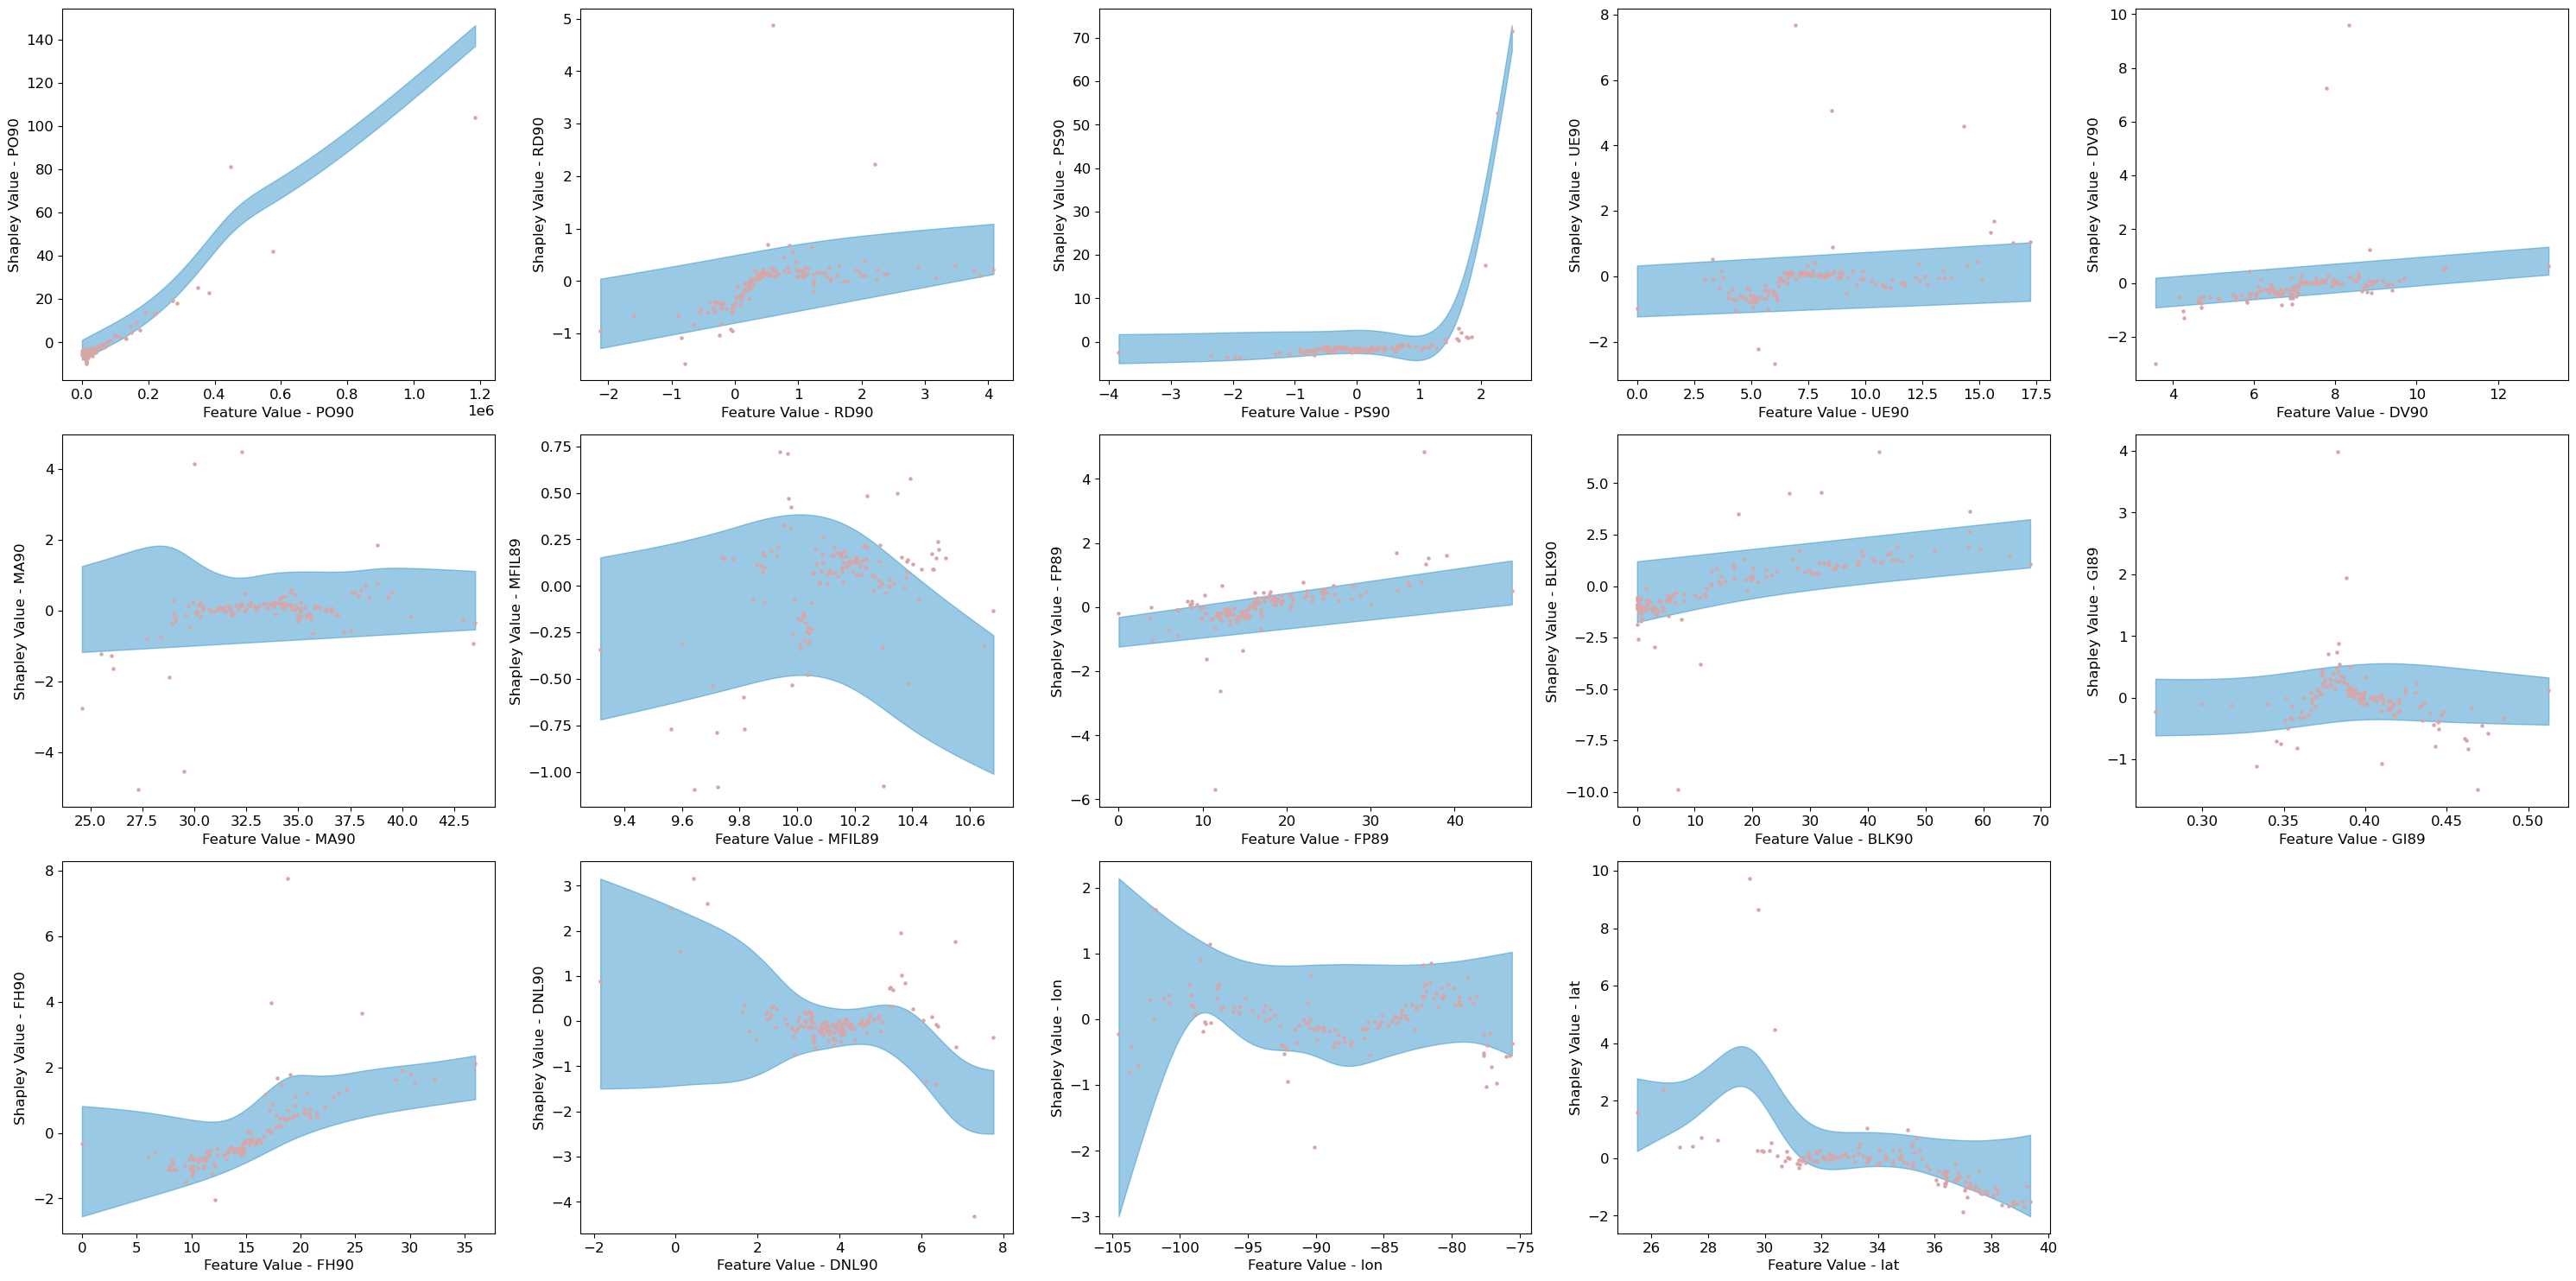

In [20]:
results.plot_partial_dependence_with_fitted_bounds(filename='SoutheHomicides_partial_dependence_with_fitted_bounds.pdf')